In [2]:
%pylab inline 
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import flowpm
import flowpm.tfpower as tfpower
import flowpm.scipy.interpolate as interpolate
from DifferentiableHOS.pk import pk as pkl
import jax_cosmo.transfer as tklibimport 
import jax_cosmo as jc
import jax.numpy as np
import jax

cosmo = jc.Planck15()

Populating the interactive namespace from numpy and matplotlib


In [3]:
nsteps=40
nc=128
box_size=128

In [4]:
cosmology = flowpm.cosmology.Planck15()
stages = np.linspace(0.5, 1., nsteps, endpoint=True)
# Compute linear matter power spectrum
k = tf.constant(np.logspace(-4, 1, 256), dtype=tf.float32)
pk = tfpower.linear_matter_power(cosmology, k)
pk_fun = lambda x: tf.cast(tf.reshape(interpolate.interp_tf(tf.reshape(tf.cast(x, tf.float32), [-1]), k, pk), x.shape), tf.complex64)

# And initial conditions
initial_conditions = flowpm.linear_field([nc, nc, nc],
                                       [box_size, box_size,
                                      box_size],
                                       pk_fun,
                                       batch_size=1)

state = flowpm.lpt_init(cosmology, initial_conditions, 0.5)


# Evolve particles from initial state down to a=af
final_state = flowpm.nbody(cosmology, state, stages, [nc, nc, nc])         

# Retrieve final density field i.e interpolate the particles to the mesh
final_field = flowpm.cic_paint(tf.zeros_like(initial_conditions), final_state[0])
final_field=tf.reshape(final_field, [nc, nc, nc])


In [5]:
k, power_spectrum = pkl(final_field,shape=final_field.shape,boxsize=np.array([box_size, box_size,
                                           box_size]),kmin=0.01,dk=2*np.pi/box_size)


In [6]:
ps_jax_nonlinear=jc.power.nonlinear_matter_power(cosmo, k,a=1.0)
ps_jax_linear=jc.power.linear_matter_power(cosmo, k,a=1.0)

/Users/dl264294/.local/lib/python3.8/site-packages/jax/_src/lax/lax.py:6081: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


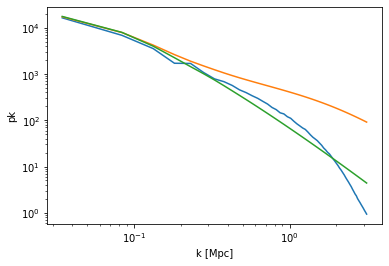

In [7]:
loglog(k,power_spectrum,label='Flowpm')
loglog(k,ps_jax_nonlinear,label='jax_cosmo non linear')
loglog(k,ps_jax_linear,label='jax_cosmo linear')

xlabel('k [Mpc]')
ylabel('pk');